There are many of them what we are going to consider here is decision tree. If we have time we are going to do nearest neighborhood too.

# Decision Tree

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import math
import pydot
from IPython.display import Image, display
from collections import namedtuple

Let us consider the data below.

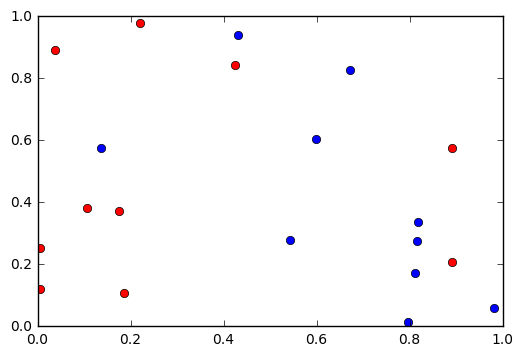

In [2]:
np.random.seed(100)
xs = np.random.random((20,2))
#print xs
cls = np.random.randint(0,2,20)*2-1
#print cls
plt.plot(xs[cls>0,0], xs[cls>0,1], 'ob')
plt.plot(xs[cls<0,0], xs[cls<0,1], 'or')

1) Try to make a classifier with several if statements.

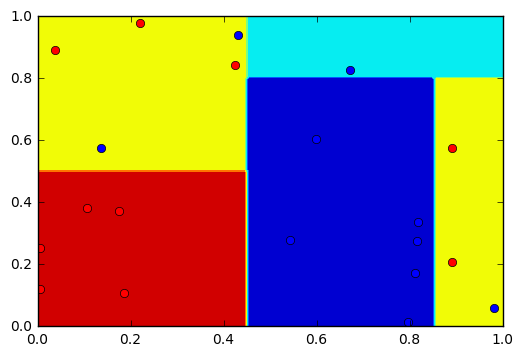

In [8]:
def bunch_of_ifs(data):
    x1,x2 = data
    if x1 < 0.45:
        if x2 < 0.5:
            return 1.0
        else:
            return 2./3
    else:
        if x2 < 0.8:
            if x1 < 0.85:
                return 0
            else:
                return 2./3
        else:
            return 1./3
    raise Exception("Shouldnt reach here")
x1s = np.linspace(0,1,100)
x2s = np.linspace(0,1,100)
zs = np.zeros((100,100))
for ix1,x1 in enumerate(x1s):
    for ix2,x2 in enumerate(x2s):
        zs[ix1,ix2] = bunch_of_ifs([x1,x2])
plt.contourf(x1s, x2s,zs.T)
plt.plot(xs[cls>0,0], xs[cls>0,1], 'ob')
plt.plot(xs[cls<0,0], xs[cls<0,1], 'or')

2) We want to represent the code above with a tree. Try draw your code above with a tree.

In [3]:
#Here are some helpers
#node must have field left and right representing left and right node.
#the label on the node is from __str__ method
def visualize_tree(node, depth_limit=10):
    graph = pydot.Dot(graph_type='digraph')
    visualize_tree_helper(node, graph, 0, depth_limit=depth_limit)
    display(Image(graph.create_png()))
    return graph
    
def visualize_tree_helper(node, graph, depth, depth_limit=10):
    
    if depth > depth_limit:
        print 'Traversing too deep'
        dotnode = pydot.Node('n%d'%id(node), label=str(node), shape="diamond", fillcolor="green", style="filled")
        graph.add_node(dotnode)
        return dotnode
    
    
    if not node.is_leaf():
        dotnode = pydot.Node('n%d'%id(node),label=str(node), shape="box")
    else:
        dotnode = pydot.Node('n%d'%id(node),label=str(node), shape="ellipse")
    graph.add_node(dotnode)
    
    if node.left is not None:
        dotleft = visualize_tree_helper(node.left, graph, depth+1, depth_limit)
        edge = pydot.Edge(dotnode, dotleft, label="Y")
        graph.add_edge(edge)
    if node.right is not None:
        dotright = visualize_tree_helper(node.right, graph, depth+1, depth_limit)
        edge = pydot.Edge(dotnode, dotright, label="N")
        graph.add_edge(edge)
    return dotnode

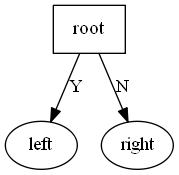

In [4]:
class Node:
    def __init__(self, msg='label'):
        self.left = None
        self.right = None
        self.msg = msg
        
    def is_leaf(self):
        return self.left is None and self.right is None
    
    def __str__(self):
        return self.msg
test_root = Node('root')
test_root.left = Node('left')
test_root.right = Node('right')
graph = visualize_tree(test_root)

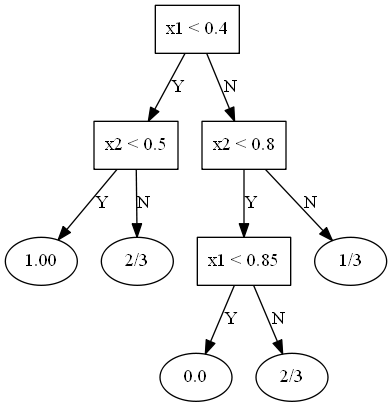

In [12]:
root = Node('x1 < 0.4')
root.left = Node('x2 < 0.5')
root.right = Node('x2 < 0.8')

root.left.left = Node('1.00')
root.left.right = Node('2/3')

root.right.left = Node('x1 < 0.85')
root.right.right = Node('1/3')

root.right.left.left = Node('0.0')
root.right.left.right = Node('2/3')
graph_ =visualize_tree(root)

3) But we want our tree to be able to classify and not just draw a nice picture.

This means that 

- our tree should have a method call classify(data)
- each (decision) node should be able to make decision(Think about what info you need to do that).
- leaf node should just holds the probability.

Implement this (Subclass Node). (Debug it with visualize tree)

Note that calling super constructor in python is a bit weird: you will need to do:

``Node.__init__(self)`` within constructor

In [54]:
class DecisionNode(Node):
    def __init__(self,vid=None,cut=None,prob = -1.):
        Node.__init__(self)
        self.vid = vid 
        self.cut = cut
        self.prob = prob
    def classify(self,features):
        if self.is_leaf():
            return self.prob
        if features[self.vid] < self.cut and self.left != None:
            return self.left.classify(features)
        elif features[self.vid] > self.cut and self.right != None:
            return self.right.classify(features)
        
    def __str__(self):
        if not self.is_leaf():
            return "x%d < %.2f"%(self.vid,self.cut)
        else:
            return '%.2f'%self.prob

0.333333333333


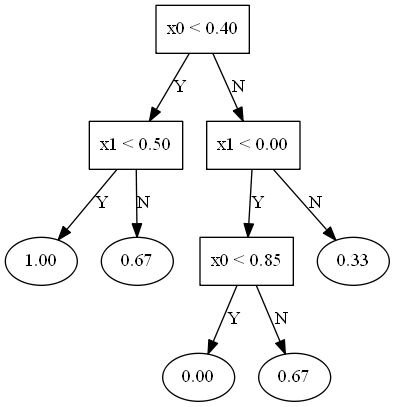

In [55]:
root = DecisionNode(0, 0.4)
root.left = DecisionNode(1, 0.5)
root.left.left = DecisionNode(prob=1.)
root.left.right = DecisionNode(0,0,2./3)
root.right = DecisionNode(1, 0.)
root.right.left = DecisionNode(0, 0.85) 
root.right.right = DecisionNode(prob=1./3)
root.right.left.left = DecisionNode(prob=0.)
root.right.left.right = DecisionNode(prob=2./3)

print root.classify([0.8, 0.9])
graph_ =visualize_tree(root)

4) Another way to visualize tree is by contour plot.

http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.contourf

Draw contour plot of the tree you had in 3)

Of course, we are not going to build this tree by hands. Our goal is to build a program which read the data and build a good tree. (Finding the best tree is probably NP problem.) So we are gonna go greedy here.


5) How do we pick the best split(which variable and where)? What does it mean intuitively?

6) Write a function: given features and class and pick the best split. (Think about how we should represent split?)

In [60]:
def gini(cls):
    p = sum(clas>0) / float(len(cls))
    return p*(1-p)

def find_cut(features, cls):
    nfeatures = features.shape[1]
    result = []
    #min_, max_ = min(features[:,]), max(features[:,])
    for vid in range(nfeatures):
        min_, max_ = min(features[:,vid]), max(features[:,vid])
        cuts = np.linspace(min_, max_, 10)
        for each in cuts:
            left_i = features[:,vid] < cut
            right_i = features[:,vid] >= cut
            left = sum(left_i)
            right = sum(right_i)
            gini_left = gini(cls[left_i])
            gini_right = gini(cls[right_i])
            score = 
            
        
find_cut(features, cls)

-3.99092085681 3.99762114648
-3.99979271717 3.99354996544


7) We want to grow a decision tree we need to stop somewhere. When should we stop?

8) Now consider this data. Write a function that grow decision tree. Of course, you will need to 

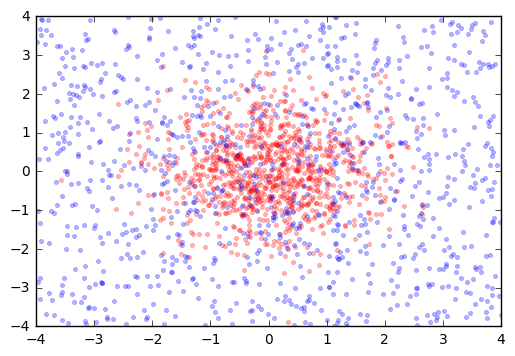

In [57]:
np.random.seed(1234)
xp1 = np.random.randn(1000,1)
xp2 = np.random.randn(1000,1)
pcls = np.zeros((1000))
pcls[:] = 1
xn1 = np.random.random((1000,1))*8-4
xn2 = np.random.random((1000,1))*8-4
ncls = np.zeros((1000))
ncls[:] = -1
x1s = np.concatenate([xp1, xn1])
x2s = np.concatenate([xp2, xn2])
cls = np.concatenate([pcls, ncls])
features = np.concatenate((x1s, x2s), axis=1)

cls>0
plt.plot(features[cls>0, 0], features[cls>0, 1], '.r', alpha=0.3)
plt.plot(features[cls<0, 0], features[cls<0, 1], '.b', alpha=0.3)

9) Visualize what you build with contour plot. What do you see? Why do you think that happen?

10) What is the advantage of this method over stuff like linear regression?

11) What happen if minleaf is too small?

In [ ]:
# overfit

12) Just for fun. Try linear regression on this. (What do you expect and what do you see?)

13) Try logistic regression with (How do I know that we need this transformation?)
$$(x_1, x_2) \to (1, x_1,x_1^2,x_2, x_2^2, x_1x_2)$$